In [37]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from tqdm.notebook import tqdm
from numba import jit
from time import time

plt.rcParams["figure.figsize"] = (8,6)

## Establish Parameters for Cake and Refrigerator environment

In [38]:
cp_air = 1000 #J/ ( kg K )
rho_air = 1.208 # kg/m^3
k_air = .0244 #W/ (m k)
cp_cake = 2389 #J / (kg K)
rho_cake = 220 #kg / m^3
k_cake = .072 #W/ (m k)

k_cake = 0.16 # W/ (m k)

alpha_air = k_air / (rho_air * cp_air)
alpha_cake = k_cake / (rho_cake * cp_cake)
print(alpha_air)
print(alpha_cake)

2.019867549668874e-05
3.044255869705849e-07


## Functions for completing simulation

In [39]:
def make_sim(max_time):
    print("3D heat equation solver")

    act_plate_length = .5 #meters
    cake_length = .25 #meters
    delta_x = .01

    plate_length = int(act_plate_length/delta_x)

    cake_low = int((act_plate_length-cake_length)/(delta_x*2))
    cake_high = int(plate_length-cake_low)
    print(plate_length)

    delta_t = (delta_x ** 2)/(4 * alpha_air) #find appropriate sized time step (for both alphas)
    
    max_iter_time = int(np.ceil(max_time/delta_t))
    
    print(delta_t)
    gamma_air = (alpha_air * delta_t) / (delta_x ** 2) #use alphas to find gammas
    gamma_cake = (alpha_cake * delta_t) / (delta_x ** 2)
    tspace = np.linspace(0,delta_t*max_iter_time,max_iter_time)

    # Initialize solution: the grid of u(l,i,j,k)
    u = np.empty((max_iter_time, int(plate_length), int(plate_length),int(plate_length)))

    # Initial condition everywhere inside the grid
    u_initial = 272 #27* F in Kelvin

    #u_initial = 293 #room temperature
    rm_temp = 293
    # Set the initial condition
    u.fill(u_initial)
    #u.fill(u_initial)

    u[0,cake_low:cake_high,cake_low:cake_high,cake_low:cake_high] = 366 #200 F in Kelvin

    mid = int(.5*(cake_low+cake_high))

    u_air = np.where(u[0] < 350)
    air_temps = np.zeros((max_iter_time,),dtype = np.float64)
    n_air = len(u_air[0])
    print("n_air",n_air)
    print("exp_n_air",plate_length**3 - (cake_high-cake_low)**3)

    k_r = (k_cake/k_air)
    print("kr",k_r)
    

    u = calculate(u = u,l_start = 0, l_end = max_iter_time,
                                                 plate_length = plate_length,cake_low = cake_low,
                                                 cake_high = cake_high,gamma_cake = gamma_cake,
                                                delta_x = delta_x,k_r = k_r,n_air = n_air,u_air = u_air,
                                                u_initial = u_initial,fridge = True, delta_t = delta_t)

    return u,delta_t,mid,cake_low,cake_high,tspace,u_initial
    
@jit(nopython=True)
def calculate(u,l_start = 0,l_end = 0,fridge = True,plate_length=0,cake_low = 0,cake_high = 0,
              gamma_cake = 0,delta_x = 0,k_r = 0,n_air = 0,u_air = 0,u_initial = 0,rm_temp = 293,delta_t = 1):
    total_heat = [0.0]*(l_end-l_start-1)
    cake_bound = [0.0]*(l_end-l_start-1)
    air_bound = [0.0]*(l_end-l_start-1)
    air_bound_prev = 272.0
    for l in range(l_start, l_end-1):
        for i in np.arange(plate_length):
            for j in np.arange(plate_length):
                for k in np.arange(plate_length):
                    if (i >= cake_low and i < cake_high and j >= cake_low 
                            and j < cake_high and k >= cake_low and k < cake_high): 
                        #if we're in the cake, use gamma2
                        u[l+1,i,j,k] = gamma_cake * (u[l][i+1][j][k] + u[l][i-1][j][k] + 
                                                 u[l][i][j+1][k] + u[l][i][j-1][k] +
                                                 u[l][i][j][k+1] + u[l][i][j][k-1] -
                                                 6*u[l][i][j][k]) + u[l][i][j][k]
                    else: #if we're not in the cake
                        u[l+1][i][j][k] = u[l][i][j][k]
                        
                        
        for i in np.arange(cake_low+1,cake_high-1):     #solve top and bottom boundaries, neglect edges
            for j in np.arange(cake_low+1,cake_high-1):
                k = cake_low
                u[l+1][i][j][k] = (u[l+1][i][j][k-2] + k_r * u[l+1][i][j][k+1] ) / (k_r+1)
                u[l+1][i][j][k-1] = u[l+1][i][j][k]
                k = cake_high-1
                u[l+1][i][j][k] = (u[l+1][i][j][k+2] + k_r * u[l+1][i][j][k-1] ) / (k_r+1)
                u[l+1][i][j][k+1] = u[l+1][i][j][k]
        for j in np.arange(cake_low+1,cake_high-1):     #Solve left and right boundaries, neglect edges
            for k in np.arange(cake_low+1,cake_high-1):
                i = cake_low
                u[l+1][i][j][k] = (u[l+1][i-2][j][k] + k_r * u[l+1][i+1][j][k] ) / (k_r+1)
                u[l+1][i-1][j][k] = u[l+1][i][j][k]
                i = cake_high-1
                u[l+1][i][j][k] = (u[l+1][i+2][j][k] + k_r * u[l+1][i-1][j][k] ) / (k_r+1)
                u[l+1][i+1][j][k] = u[l+1][i][j][k]
        for k in np.arange(cake_low+1,cake_high-1):
            for i in np.arange(cake_low+1,cake_high-1):     #solve front and back boundaries, neglect edges
                j = cake_low
                u[l+1][i][j][k] = (u[l+1][i][j-2][k] + k_r * u[l+1][i][j+1][k] ) / (k_r+1)
                u[l+1][i][j-1][k] = u[l+1][i][j][k]
                j = cake_high-1
                u[l+1][i][j][k] = (u[l+1][i][j+2][k] + k_r * u[l+1][i][j-1][k] ) / (k_r+1)
                u[l+1][i][j+1][k] = u[l+1][i][j][k]
                
        if fridge:
            sum_air = 0
            for i in range(n_air): #get sum of all temperatures of air
                sum_air += u[l+1,u_air[0][i],u_air[1][i],u_air[2][i]]
            sum_air_last = sum_air
            mean_air = sum_air / n_air #get mean of all temperatures of air
            for i in range(n_air):
                if mean_air > u_initial: #if the air is warmer than the fridge setting
                    u[l+1,u_air[0][i],u_air[1][i],u_air[2][i]] = mean_air - 20*120000.0  *delta_x**3 / delta_t
                    #mix the air uniformly and remove some heat 
                else:
                    u[l+1,u_air[0][i],u_air[1][i],u_air[2][i]] = mean_air # otherwise just mix the air
        else:
            for i in range(n_air): 
                u[l+1,u_air[0][i],u_air[1][i],u_air[2][i]] = rm_temp
    return u

def plotheatmap(u_k, k):
    # Clear the current plot figure
    plt.clf()

    plt.title(f"Temperature of Center Slice\nat {k*dt/60:.1f} mins\n")
    plt.xlabel("x")
    plt.ylabel("y")
    u_k_f = (u_k - 273.15) * 9/5 + 32
    # This is to plot u_k (u at time-step k)
    plt.pcolormesh(u_k_f, cmap=plt.cm.jet, vmin=25, vmax=210)
    cbar = plt.colorbar()
    cbar.set_label('Degrees Fahrenheit', rotation=270)
    plt.tight_layout()

    return plt

## Run the Simulation

In [40]:
# Do the simulation
u,dt,mid,cake_low,cake_high,tspace,u_initial = make_sim(int(8000))
print(u.shape)

3D heat equation solver
50
1.237704918032787
n_air 107424
exp_n_air 107424
kr 6.557377049180327
(6464, 50, 50, 50)


## Show the cake's temperature over time

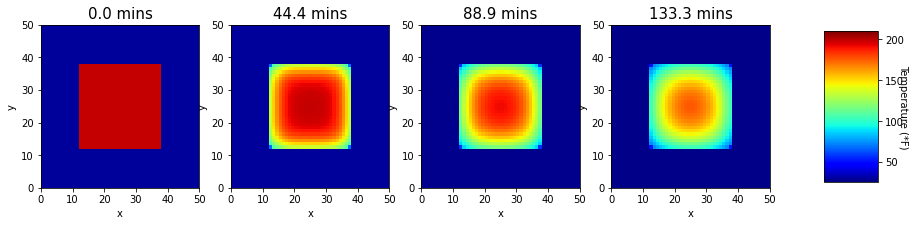

In [41]:
fig, ax = plt.subplots(1,4,figsize = (15,3))
for i,k in enumerate(np.linspace(0,u.shape[0]-1,4)):
    ki = int(k)
    u_k = u[ki,mid]
    u_k_f = (u_k - 273.15) * 9/5 + 32
    
    ax[i].set_title(f"{k*dt/60:.1f} mins",size = 15)
    ax[i].set_xlabel("x")
    ax[i].set_ylabel("y")
    im = ax[i].pcolormesh(u_k_f, cmap=plt.cm.jet, vmin=25, vmax=210)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('Temperature (*F)', rotation=270)
plt.show()


In [22]:
def k_to_f(uu):
    return (uu-273.15) * 9/5 + 32
plt.rcParams["figure.figsize"] = (10,10)

plt.rcParams["figure.figsize"] = (10,10)



|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

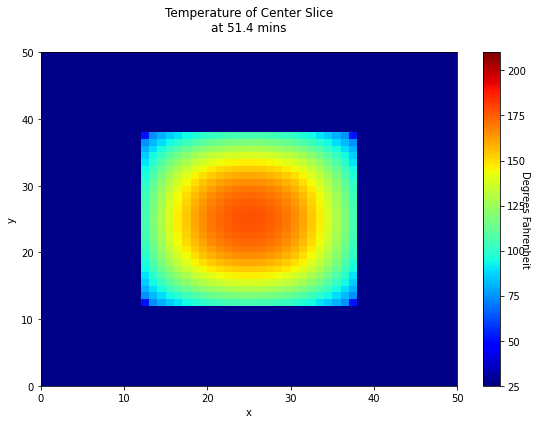

In [42]:
def animate(k):
    plotheatmap(u[k*25][mid], k*10)
    print('|',end = '')

anim = animation.FuncAnimation(plt.figure(), animate, interval=60, frames=250, repeat=False)
anim.save("heat_equation_solution.gif")

## Show temperatures at key positions within refrigerator

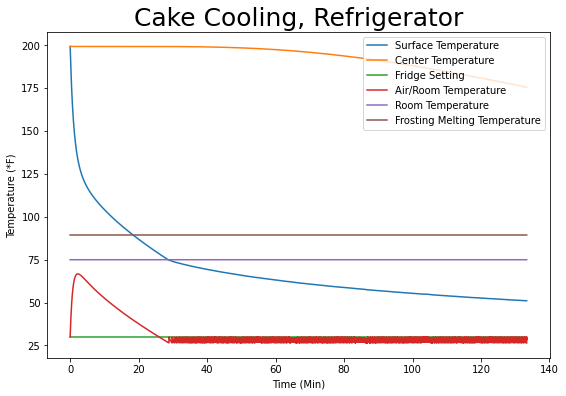

In [43]:
plt.rcParams["figure.figsize"] = (9,6)

mid = int(.5*(cake_low+cake_high))
plt.plot(tspace/60,k_to_f(u[:,cake_low,cake_low,mid]),label = "Surface Temperature")
plt.plot(tspace/60, k_to_f(u[:,mid,mid,mid]),label = "Center Temperature")
plt.plot(tspace/60, np.ones_like(tspace)*k_to_f(u_initial),label = "Fridge Setting")
plt.plot(tspace/60,k_to_f(u[:,1,1,1]),label = "Air/Room Temperature")
plt.plot(tspace/60, k_to_f(297*np.ones_like(tspace)),label = "Room Temperature")
plt.plot(tspace/60, k_to_f(305*np.ones_like(tspace)),label = "Frosting Melting Temperature")
plt.title("Cake Cooling, Refrigerator",size = 25)
plt.xlabel("Time (Min)")
plt.ylabel("Temperature (*F)")
plt.legend();

In [44]:
mins_to_surface_cool = [36,58,64,68]
dx = [.008,.01,.0125,.015]

In [45]:
## Show how dx (choice of spacial resolution) affects overall cooling time

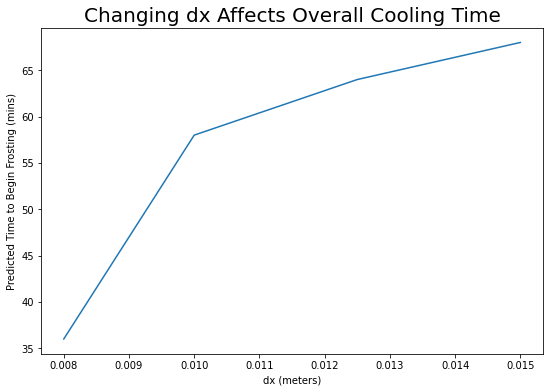

In [46]:
plt.plot(dx,mins_to_surface_cool)
plt.xlabel("dx (meters)")
plt.ylabel("Predicted Time to Begin Frosting (mins)")
plt.title("Changing dx Affects Overall Cooling Time",size = 20);

## Simulator Function for a cake in the open air (well ventilated)

In [47]:
def make_sim(max_time):
    print("3D heat equation solver")

    act_plate_length = .5 #meters
    cake_length = .1 #meters
    delta_x = .01

    plate_length = int(act_plate_length/delta_x)

    cake_low = int((act_plate_length-cake_length)/(delta_x*2))
    cake_high = int(plate_length-cake_low)
    print(plate_length)

    delta_t = (delta_x ** 2)/(4 * alpha_air) #find appropriate sized time step (for both alphas)
    
    max_iter_time = int(np.ceil(max_time/delta_t))
    
    print(delta_t)
    gamma_air = (alpha_air * delta_t) / (delta_x ** 2) #use alphas to find gammas
    gamma_cake = (alpha_cake * delta_t) / (delta_x ** 2)
    tspace = np.linspace(0,delta_t*max_iter_time,max_iter_time)

    # Initialize solution: the grid of u(l,i,j,k)
    u = np.empty((max_iter_time, int(plate_length), int(plate_length),int(plate_length)))

    # Initial condition everywhere inside the grid
    u_initial = 272 #27* F in Kelvin

    #u_initial = 293 #room temperature
    rm_temp = 293
    # Set the initial condition
    u.fill(rm_temp)
    #u.fill(u_initial)

    u[0,cake_low:cake_high,cake_low:cake_high,cake_low:cake_high] = 366 #200 F in Kelvin

    mid = int(.5*(cake_low+cake_high))

    u_air = np.where(u[0] < 350)
    air_temps = np.zeros((max_iter_time,),dtype = np.float64)
    n_air = len(u_air[0])
    print("n_air",n_air)
    print("exp_n_air",plate_length**3 - (cake_high-cake_low)**3)

    k_r = (k_cake/k_air)
    print("kr",k_r)
    

    u = calculate(u = u,l_start = 0, l_end = max_iter_time,
                                                 plate_length = plate_length,cake_low = cake_low,
                                                 cake_high = cake_high,gamma_cake = gamma_cake,
                                                delta_x = delta_x,k_r = k_r,n_air = n_air,u_air = u_air,
                                                u_initial = u_initial,fridge = False, delta_t = delta_t)

    return u,delta_t,mid,cake_low,cake_high,tspace,u_initial
    
@jit(nopython=True)
def calculate(u,l_start = 0,l_end = 0,fridge = True,plate_length=0,cake_low = 0,cake_high = 0,
              gamma_cake = 0,delta_x = 0,k_r = 0,n_air = 0,u_air = 0,u_initial = 0,rm_temp = 293,delta_t = 1):
    total_heat = [0.0]*(l_end-l_start-1)
    cake_bound = [0.0]*(l_end-l_start-1)
    air_bound = [0.0]*(l_end-l_start-1)
    air_bound_prev = 272.0
    for l in range(l_start, l_end-1):
        for i in np.arange(plate_length):
            for j in np.arange(plate_length):
                for k in np.arange(plate_length):
                    if (i >= cake_low and i < cake_high and j >= cake_low 
                            and j < cake_high and k >= cake_low and k < cake_high): 
                        #if we're in the cake, use gamma2
                        u[l+1,i,j,k] = gamma_cake * (u[l][i+1][j][k] + u[l][i-1][j][k] + 
                                                 u[l][i][j+1][k] + u[l][i][j-1][k] +
                                                 u[l][i][j][k+1] + u[l][i][j][k-1] -
                                                 6*u[l][i][j][k]) + u[l][i][j][k]
                    else: #if we're not in the cake
                        u[l+1][i][j][k] = u[l][i][j][k]
                        
                        
        for i in np.arange(cake_low+1,cake_high-1):     #solve top and bottom boundaries
            for j in np.arange(cake_low+1,cake_high-1):
                k = cake_low
                u[l+1][i][j][k] = (u[l+1][i][j][k-2] + k_r * u[l+1][i][j][k+1] ) / (k_r+1)
                u[l+1][i][j][k-1] = u[l+1][i][j][k]
                k = cake_high-1
                u[l+1][i][j][k] = (u[l+1][i][j][k+2] + k_r * u[l+1][i][j][k-1] ) / (k_r+1)
                u[l+1][i][j][k+1] = u[l+1][i][j][k]
        for j in np.arange(cake_low+1,cake_high-1):     #Solve left and right boundaries
            for k in np.arange(cake_low+1,cake_high-1):
                i = cake_low
                u[l+1][i][j][k] = (u[l+1][i-2][j][k] + k_r * u[l+1][i+1][j][k] ) / (k_r+1)
                u[l+1][i-1][j][k] = u[l+1][i][j][k]
                i = cake_high-1
                u[l+1][i][j][k] = (u[l+1][i+2][j][k] + k_r * u[l+1][i-1][j][k] ) / (k_r+1)
                u[l+1][i+1][j][k] = u[l+1][i][j][k]
        for k in np.arange(cake_low+1,cake_high-1):
            for i in np.arange(cake_low+1,cake_high-1):     #solve front and back boundaries
                j = cake_low
                u[l+1][i][j][k] = (u[l+1][i][j-2][k] + k_r * u[l+1][i][j+1][k] ) / (k_r+1)
                u[l+1][i][j-1][k] = u[l+1][i][j][k]
                j = cake_high-1
                u[l+1][i][j][k] = (u[l+1][i][j+2][k] + k_r * u[l+1][i][j-1][k] ) / (k_r+1)
                u[l+1][i][j+1][k] = u[l+1][i][j][k]
                
        if fridge:
            sum_air = 0
            for i in range(n_air): #get sum of all temperatures of air
                sum_air += u[l+1,u_air[0][i],u_air[1][i],u_air[2][i]]
            sum_air_last = sum_air
            mean_air = sum_air / n_air #get mean of all temperatures of air
            for i in range(n_air):
                if mean_air > u_initial: #if the air is warmer than the fridge setting
                    u[l+1,u_air[0][i],u_air[1][i],u_air[2][i]] = mean_air - 120000.0  *delta_x**3 / delta_t
                    #mix the air uniformly and remove some heat 
                else:
                    u[l+1,u_air[0][i],u_air[1][i],u_air[2][i]] = mean_air # otherwise just mix the air
        else:
            for i in range(n_air): 
                u[l+1,u_air[0][i],u_air[1][i],u_air[2][i]] = rm_temp
    return u

def plotheatmap(u_k, k):
    # Clear the current plot figure
    plt.clf()

    plt.title(f"Temperature: {k*dt/60:.1f} mins\nAt Center Slice")
    plt.xlabel("x")
    plt.ylabel("y")
    u_k_f = (u_k - 273.15) * 9/5 + 32
    # This is to plot u_k (u at time-step k)
    plt.pcolormesh(u_k_f, cmap=plt.cm.jet, vmin=25, vmax=210)
    cbar = plt.colorbar()
    cbar.set_label('Degrees Fahrenheit', rotation=270)
    plt.tight_layout()

    return plt

## Perform open-air simulation

In [48]:

u,dt,mid,cake_low,cake_high,tspace,u_initial = make_sim(int(8000))
print(u.shape)

3D heat equation solver
50
1.237704918032787
n_air 124000
exp_n_air 124000
kr 6.557377049180327
(6464, 50, 50, 50)


## Show temperatures at key positions over time

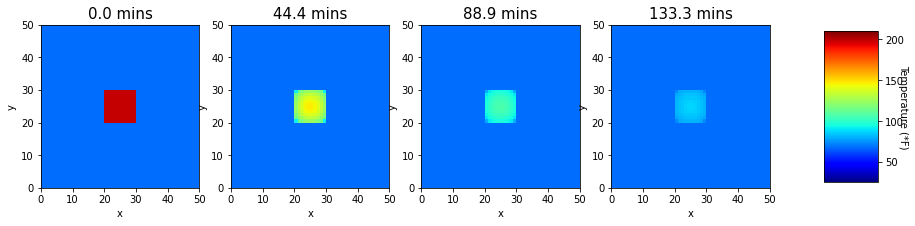

In [49]:
fig, ax = plt.subplots(1,4,figsize = (15,3))
for i,k in enumerate(np.linspace(0,u.shape[0]-1,4)):
    ki = int(k)
    u_k = u[ki,mid]
    u_k_f = (u_k - 273.15) * 9/5 + 32
    
    ax[i].set_title(f"{k*dt/60:.1f} mins",size = 15)
    ax[i].set_xlabel("x")
    ax[i].set_ylabel("y")
    im = ax[i].pcolormesh(u_k_f, cmap=plt.cm.jet, vmin=25, vmax=210)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('Temperature (*F)', rotation=270)

## Show cooling progress over time in open air

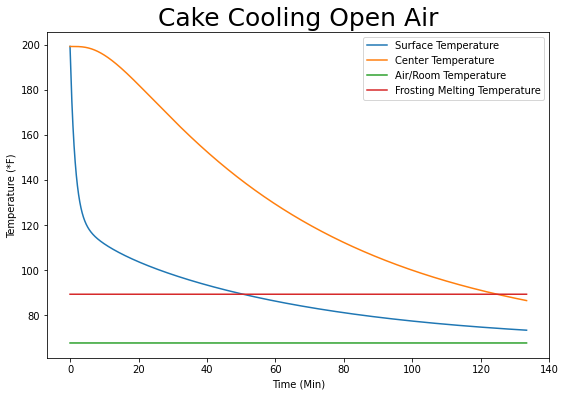

In [50]:
plt.rcParams["figure.figsize"] = (9,6)

mid = int(.5*(cake_low+cake_high))
plt.plot(tspace/60,k_to_f(u[:,cake_low,cake_low,mid]),label = "Surface Temperature")
plt.plot(tspace/60, k_to_f(u[:,mid,mid,mid]),label = "Center Temperature")
#plt.plot(tspace/60, np.ones_like(tspace)*k_to_f(u_initial),label = "Fridge Setting")
plt.plot(tspace/60,k_to_f(u[:,1,1,1]),label = "Air/Room Temperature")
plt.plot(tspace/60, k_to_f(305*np.ones_like(tspace)),label = "Frosting Melting Temperature")
plt.title("Cake Cooling Open Air",size = 25)
plt.xlabel("Time (Min)")
plt.ylabel("Temperature (*F)")
plt.legend();